In [2]:
import os  

modules = [  
    "torch",  
    "transformers",  
    "pandas",  
    "numpy",  
    "scikit-learn",  
    "imblearn",  
    "nltk" ,
    "matplotlib",
]  

for module in modules:  
    os.system(f"pip install {module}")  

print("✅ All modules installed!")  


✅ All modules installed!


In [3]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import RobertaTokenizer, RobertaModel
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

df = pd.read_csv("/kaggle/input/new-hsioa/final_labels.csv")  
df.dropna(subset=['body', 'level_1', 'split'], inplace=True)
df = df.reset_index(drop=True)

train_df = df[df['split'] == 'train'].reset_index(drop=True)
test_df = df[df['split'] == 'test'].reset_index(drop=True)

tokenizer = RobertaTokenizer.from_pretrained("roberta-base")

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(texts.tolist(), truncation=True, padding=True, max_length=128, return_tensors="pt")
        self.labels = torch.tensor(labels.tolist(), dtype=torch.long)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {key: val[idx] for key, val in self.encodings.items()}, self.labels[idx]

target_labels = {label: idx for idx, label in enumerate(df['level_1'].unique())}
y_train = train_df['level_1'].map(target_labels)
y_test = test_df['level_1'].map(target_labels)

train_dataset = TextDataset(train_df['body'], y_train)
test_dataset = TextDataset(test_df['body'], y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

class RobertaClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.roberta = RobertaModel.from_pretrained("roberta-base")
        self.fc = nn.Linear(self.roberta.config.hidden_size, num_classes)
    
    def forward(self, input_ids, attention_mask):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        return self.fc(outputs.pooler_output)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RobertaClassifier(len(target_labels)).to(device)
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)

def train_model():
    model.train()
    for epoch in range(5):
        total_loss = 0
        for batch, labels in train_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(**batch)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

def evaluate_model():
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch, labels in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            labels = labels.to(device)
            outputs = model(**batch)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")

train_model()
evaluate_model()


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Loss: 0.2697
Epoch 2, Loss: 0.1694
Epoch 3, Loss: 0.1118
Epoch 4, Loss: 0.0728
Epoch 5, Loss: 0.0339
Accuracy: 0.9393, Precision: 0.9342, Recall: 0.9393, F1: 0.9328


In [4]:
import torch
import re
from transformers import RobertaTokenizer, RobertaForSequenceClassification, BartForConditionalGeneration, BartTokenizer

# Load RoBERTa model for detection
roberta_tokenizer = RobertaTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-hate")
roberta_model = RobertaForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-hate")

# Load BART model for rewriting
bart_tokenizer = BartTokenizer.from_pretrained("eugenesiow/bart-paraphrase")
bart_model = BartForConditionalGeneration.from_pretrained("eugenesiow/bart-paraphrase")

# Function to detect misogynistic text
def detect_misogyny(text):
    inputs = roberta_tokenizer(text, return_tensors="pt", truncation=True, max_length=128)
    outputs = roberta_model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1)
    return probs[0][1].item() > 0.5  # If misogyny score > 0.5, it's flagged

# Function to highlight problematic words
def highlight_misogyny(text):
    words = text.split()
    highlighted_text = text
    for word in words:
        if detect_misogyny(word):  # Check each word
            highlighted_text = re.sub(rf'\b{re.escape(word)}\b', f'**{word}**', highlighted_text, flags=re.IGNORECASE)
    return highlighted_text

# Function to rewrite flagged text
def rewrite_text(text):
    input_ids = bart_tokenizer(text, return_tensors="pt", truncation=True, max_length=128).input_ids
    output_ids = bart_model.generate(input_ids, max_length=128, num_return_sequences=1, do_sample=True, temperature=0.7)
    return bart_tokenizer.decode(output_ids[0], skip_special_tokens=True)

# Example usage
text = "Women should not be in leadership positions!"
if detect_misogyny(text):
    highlighted = highlight_misogyny(text)
    rewritten = rewrite_text(text)
    print(f"🔴 Problematic: {highlighted}")
    print(f"✅ Suggested: {rewritten}")
else:
    print("✅ No issues detected.")


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/332 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.69k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

🔴 Problematic: **Women** should not be in leadership positions!
✅ Suggested: Why should women not be in leadership positions?


In [5]:
def moderate_comment(text):
    model.eval()
    encoding = tokenizer(text, truncation=True, padding=True, max_length=128, return_tensors="pt")
    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask)  # Only two arguments passed
        prediction = torch.argmax(outputs, dim=1).item()

    return "🚨 Potential issue detected!" if prediction == 1 else "✅ No issues detected."

print(moderate_comment("Women should never drive. Just kidding!"))
print(moderate_comment("Women should never drive."))

✅ No issues detected.
🚨 Potential issue detected!


Accuracy: 0.9393, Precision: 0.9342, Recall: 0.9393, F1: 0.9328


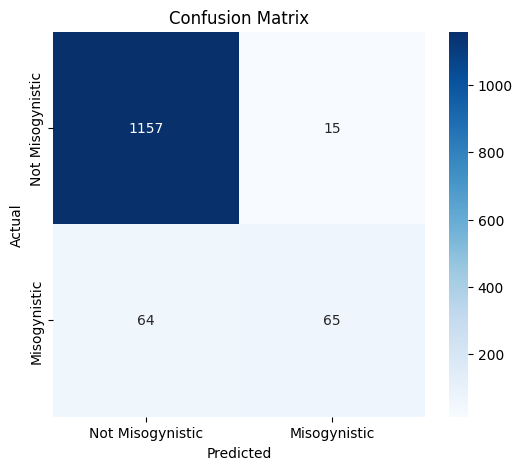

In [6]:
def evaluate_model():
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch, labels in test_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            labels = labels.to(device)
            outputs = model(**batch)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    rec = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
    print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
    return all_labels,all_preds

all_labels,all_preds = evaluate_model()

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def visualize_results(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Misogynistic", "Misogynistic"], yticklabels=["Not Misogynistic", "Misogynistic"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

y_true = all_labels
y_pred = all_preds
visualize_results(y_true, y_pred)
